# RRT*

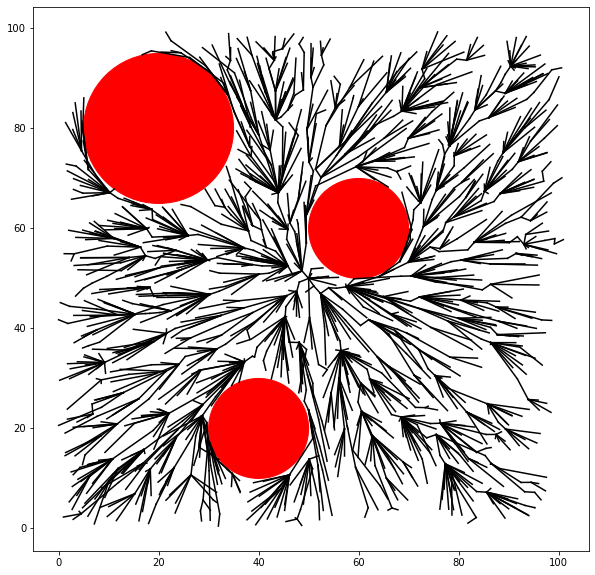

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

import sys

class Node():
    def __init__(self, pos):
        self.pos = pos
        self.cost = sys.maxsize
        self.parent = None

class Graph():
    def __init__(self, q_init):        
        self.start_p = q_init[0][0]
        self.end_p = q_init[0][1]
        
        start = Node(q_init[1])
        start.cost = 0
        self.nodes = np.array([start])
        
        self.tree = plt.figure()
        plt.gca().set_aspect('equal')
        self.tree.set_size_inches(10, 10)
        
        self.obstacles = q_init[2]
        
        for obstacle in self.obstacles:
            circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', figure = self.tree)
            plt.gca().add_patch(circle)
        
    def rand_config(self):
        rand_pos = self.start_p + (self.end_p - self.start_p) * [np.random.random_sample(), 
                                                                 np.random.random_sample()]
        return rand_pos
    
    def nearest_vertex(self, q):
        dist = None
        nearest = None
        for node in self.nodes:
            curr_dist = np.linalg.norm(q - node.pos)
            if dist is None or curr_dist < dist:
                dist = curr_dist
                nearest = node
        return nearest
    
    def line_collides(self, p1, p2):
        line_dir = p2 - p1
        a = np.dot(line_dir, line_dir)

        for obstacle in self.obstacles:
            center = np.array([obstacle[0], obstacle[1]])
            radius = obstacle[2]
            
            center_p1_dir = p1 - center
            b = 2 * np.dot(line_dir, center_p1_dir)
            c = np.dot(center_p1_dir, center_p1_dir) - radius * radius

            discrim = b * b - 4 * a * c
            if discrim < 0: # no intersection
                continue
            t1 = (-b + np.sqrt(discrim)) / (2 * a);
            t2 = (-b - np.sqrt(discrim)) / (2 * a);

            if (t1 >= 0 and t1 <= 1) or (t2 >= 0 and t2 <= 1):
                return True

        return False
    
    def plot_edge(self, p1, p2):
        refactor_p1, refactor_p2 = [p1[0], p2[0]], [p1[1], p2[1]]
        plt.plot(refactor_p1, refactor_p2, 'k-', figure = self.tree)

def build_rrt(q_init, K, delta, search_rad):
    #RRT* rad
    graph = Graph(q_init)
    for _ in range(K):
        q_rand = graph.rand_config()
        node_near = graph.nearest_vertex(q_rand)
        
        dir_norm = np.linalg.norm(q_rand - node_near.pos)
        if dir_norm != 0: #very unlikely?
            q_new = node_near.pos + delta * (q_rand - node_near.pos) / dir_norm
            
            if not graph.line_collides(node_near.pos, q_new):
                new_node = Node(q_new)
                new_node.parent = node_near
                new_node.cost = node_near.cost + dir_norm

                for node in graph.nodes:
                    if np.linalg.norm(node.pos - new_node.pos) < search_rad:
                        agg_cost = node.cost + np.linalg.norm(node.pos - new_node.pos)
                        if agg_cost < new_node.cost and not graph.line_collides(node.pos, new_node.pos):
                            new_node.parent = node
                            new_node.cost = agg_cost

                for node in graph.nodes:
                    if np.linalg.norm(node.pos - new_node.pos) < search_rad:
                        agg_cost = new_node.cost + np.linalg.norm(node.pos - new_node.pos)
                        if agg_cost < node.cost and not graph.line_collides(node.pos, new_node.pos):
                            node.parent = new_node
                            node.cost = agg_cost

                graph.nodes = np.append(graph.nodes, new_node)
    for node in graph.nodes:
        if node.parent:
            graph.plot_edge(node.pos, node.parent.pos)

# q_init = ([LL UR], [verts], [obstacles (x, y, radius)])
q_init = [np.array([[0, 0], [100, 100]]), 
          [50., 50.],
          np.array([[60, 60, 10], [20, 80, 15], [40, 20, 10]])
         ]
build_rrt(q_init, 2000, 2, 10)